# A notebook in R for modelling species distributions using the standard Maximum Entropy Model

In this notebook we will compute the Maximum Entropy model for predicting species distributions using presence-only data. This method has been the cannonical model in predicting species records that lack real absences. 
For achiving this we will use the R package maxnet (cite article 2017, black box), an *Open Source* version of the MaxEnt java application used in earlier studies (Philips, et.al 2006).

The MaxEnt model requires three data sources: i) environmental (covariates), ii) occurrence records (species presence) and ii) background sample (independent environmental locations).
For the purposes of this comparison we will use the same background sample as in the Presence-only models (CAR). 

## Caveats
The MaxEnt model is a pointwise model

No smapling bias , taken all data



In [1]:
library(dplyr)
library(purrr)
library(biospytial.rwrapper)
#install.packages('maxnet')
library(maxnet)

## Import code:
setwd('/apps/external_plugins/biospytial_rwrapper/biospytial.rwrapper/R/')
## Import functions for obtaining Presences, Absences and NAs
source("SpeciesModels.R")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
## Read adjancency matrix
mat_filename = "/outputs/training_data_sample_puebla_p9_abies_pinophyta_adjmat.npy"
library(reticulate)
np <- import("numpy")
M <- np$load(mat_filename)
TDF = read.csv("/outputs/training_data_sample_puebla_p9_abies_pinophyta.csv")
## Order it according to the id of the cell
## This is important because the adjancy matrix rows need to be the same
TDF = TDF[order(TDF$cell_ids),]
# Convert to numeric
TDF = mutate_at(TDF,vars(Dist.to.road_m,Elevation_m,MaxTemp_m,MeanTemp_m,MinTemp_m,Population_m,Precipitation_m,SolarRadiation_m,VaporPres_m,WindSp_m),as.numeric)
names(TDF) = lapply(names(TDF),function(x) gsub("_","",x))
names(TDF) = lapply(names(TDF),function(x) gsub("\\.","",x))
                    
### Mini script para borrar entrada con 0 neighbours
D = apply(M,MARGIN = 1,sum)
idx = match(0,D)
## Please check that the order is ok
# Checked, 
cell_with_no_neighbour = TDF$cellids[idx]
## look in the gis
## Erase idx for M and for TDF (Or maybe only for M)
M_bis = M[-c(idx),-c(idx)]

names(TDF)[23] <- 'covid2'
                    
## Pinophyta Plantae                    
DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Plantae,LUCA),
                              species=pseudo_absence_trivial(Pinophyta,Plantae))

### Abies pinophyta
#DataFrame = TDF %>% rowwise() %>% mutate(sample=pseudo_absence_naive(Pinophyta,Plantae),
#                              species=pseudo_absence_trivial(Abies,Pinophyta))
                    
formula_sample=sample~Disttoroadm+Populationm #+factor(tipos)
formula_presence=species~Elevationm+MeanTempm
n <- nrow(TDF)
trials <- rep(1,n)



In [4]:
## Entire model
predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame)
maxentm = maxnet(DataFrame$species,predictors,maxnet.formula(TDF$species,predictors,classes='l'))
pred_vals = predict(maxentm,predictors,type='cloglog')

## K-fold cross validation

In [5]:
## Make ROC curve
library(pROC)
library('caret')
validate = createFolds(y = DataFrame$species, k=7, returnTrain = FALSE)

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift



In [6]:
l <- list()
i = 1
DataFrame$predicted_values_CV <- NA
for (fold in validate) {
    
    predictors = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame[fold,])
    
    train.matrix = model.frame(formula = '~Elevationm + MeanTempm',data=DataFrame[-fold,])
    
    maxentm = maxnet(DataFrame$species[-fold],train.matrix,
                     maxnet.formula(DataFrame$species[-fold],train.matrix,classes='l'))
    
    pred_vals = predict(maxentm,predictors,type='cloglog')
    
    DataFrame$predicted_values_CV[fold] <- pred_vals
    
    pROC_obj <- roc(DataFrame$species[fold],pred_vals)

    l[[i]] <- pROC_obj
    c = paste("Modeling: ",i, "out of ",length(validate))
    print(c)
    i = i + 1
}

Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  1 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  2 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  3 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  4 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  5 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  6 out of  7"


Setting levels: control = 0, case = 1
Warning message in roc.default(DataFrame$species[fold], pred_vals):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”Setting direction: controls < cases


[1] "Modeling:  7 out of  7"


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Warning message in plot.ci.se(sens.ci, type = "shape", col = "lightblue"):
“Low definition shape.”

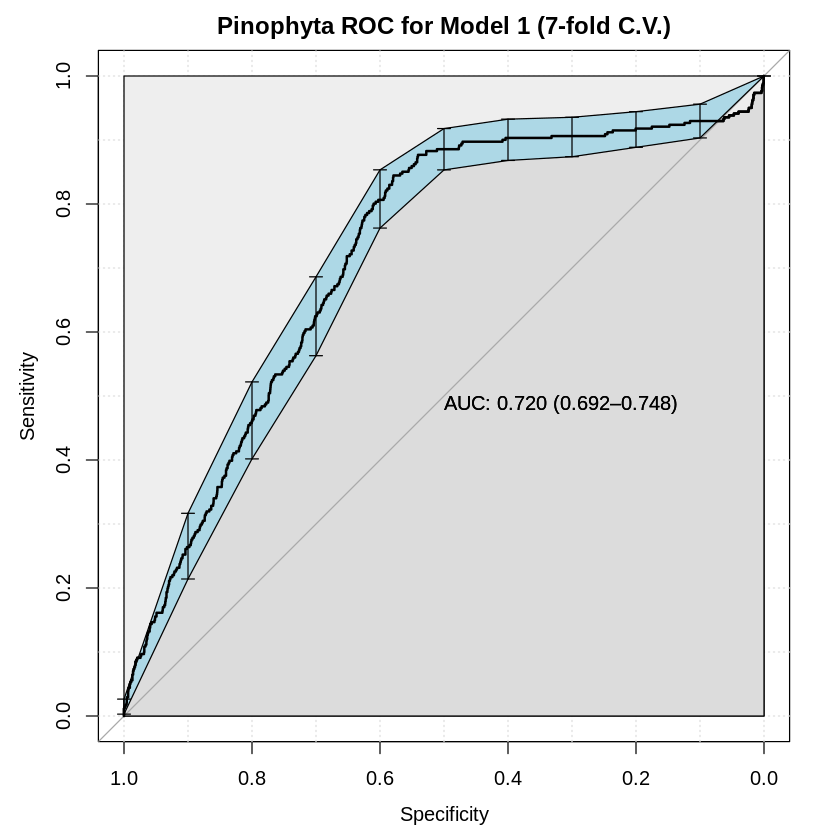

In [7]:
pROC_obj <- roc(DataFrame$species,DataFrame$predicted_values_CV,
               smoothed= TRUE,
               ci = TRUE, ci.alpha=0.9, stratified=FALSE,
               plot=TRUE, auc.polygon=TRUE, max.auc.polygon=TRUE, grid=TRUE,
               print.auc=TRUE, show.thres=TRUE,main='Pinophyta ROC for Model 1 (7-fold C.V.)')
sens.ci <- ci.se(pROC_obj)
plot(sens.ci,type="shape",col="lightblue")
plot(sens.ci, type="bars")
